In [1]:
import torch
import os

import triton
import triton.language as tl
from triton.runtime import driver

DEVICE = triton.runtime.driver.active.get_active_torch_device()


def is_hip():
    return triton.runtime.driver.active.get_current_target().backend == "hip"


def is_cdna():
    return is_hip() and triton.runtime.driver.active.get_current_target().arch in ('gfx940', 'gfx941', 'gfx942',
                                                                                   'gfx90a', 'gfx908')

In [2]:
def naive_pytorch_softmax(x):
    x_max = x.max(dim=-1)[0]
    z = x - x_max[:, None]
    numerator = torch.exp(z)
    denominator = numerator.sum(dim=-1)
    return numerator / denominator[:, None]

In [3]:
def streaming_pytorch_softmax(x, query_tile=64, feat_tile=64):


    q_len, feat_len = x.shape
    output = torch.empty_like(x)
    x_max_matrix = torch.empty_like(x[:, 0])
    ez_sum_matrix = torch.empty_like(x[:, 0])

    for q_start in range(0, q_len, query_tile):
        q_end = min(q_start + query_tile, q_len)
        q_slice = x[q_start:q_end]
        x_max = torch.ones_like(q_slice[:, 0]) * -float('inf')
        ez_sum = torch.zeros_like(q_slice[:, 0])
        for feat_start in range(0, feat_len, feat_tile):
            feat_end = min(feat_start + feat_tile, feat_len)
            current_x = q_slice[:, feat_start:feat_end]
            current_x_max = current_x.max(dim=-1)[0]
            new_x_max = torch.maximum(x_max, current_x_max)
            rescale = torch.exp(x_max - new_x_max)
            ez_sum *= rescale
            ez_sum += torch.exp(current_x - new_x_max[:, None]).sum(dim=-1)
            x_max = new_x_max

        output[q_start:q_end] = torch.exp(q_slice - x_max[:, None]) / ez_sum[:, None]
        x_max_matrix[q_start:q_end] = x_max
        ez_sum_matrix[q_start:q_end] = ez_sum
    return output

In [4]:
properties = driver.active.utils.get_device_properties(DEVICE.index)
NUM_SM = properties["multiprocessor_count"]
NUM_REGS = properties["max_num_regs"]
SIZE_SMEM = properties["max_shared_mem"]
WARP_SIZE = properties["warpSize"]
target = triton.runtime.driver.active.get_current_target()
kernels = {}

@triton.jit
def softmax_kernel(
    output_ptr,
    input_ptr,
    input_row_stride,
    output_row_stride,
    n_rows,
    n_cols,
    BLOCK_SIZE: tl.constexpr,
    num_stages: tl.constexpr,
):
    row_start = tl.program_id(0)
    row_step = tl.num_programs(0)
    for row_idx in tl.range(row_start, n_rows, row_step, num_stages=num_stages):
        row_start_ptr = input_ptr + row_idx * input_row_stride
        col_offsets = tl.arange(0, BLOCK_SIZE)
        input_ptrs = row_start_ptr + col_offsets
        mask = col_offsets < n_cols
        row = tl.load(input_ptrs, mask=mask, other=-float('inf'))
        row_minus_max = row - tl.max(row, axis=0)
        numerator = tl.exp(row_minus_max)
        denominator = tl.sum(numerator, axis=0)
        softmax_output = numerator / denominator
        output_row_start_ptr = output_ptr + row_idx * output_row_stride
        output_ptrs = output_row_start_ptr + col_offsets
        tl.store(output_ptrs, softmax_output, mask=mask)

def softmax(x):
    n_rows, n_cols = x.shape

    BLOCK_SIZE = triton.next_power_of_2(n_cols)

    # triton에서 하나의 프로그램은 하나의 행(row)를 계산한다.
    # num_warps는 하나의 프로그램(하나의 행)을 계산하는데 몇 개의 GPU warp를 사용할지 결정한다.
    # num_warps가 많은 수록 더 많은 스레드가 하나의 프로그램을 실행한다.
    # 하지만 num_warps가 커질수록 register pressure가 증가하여 활성시킬 수 있는 프로그램의 수가 적어진다.
    num_warps = 8

    # software pipelining을 이용하여 메모리 로드와 연산을 겹쳐서 실행한다.
    # 다음 tile을 SMEM으로 prefetch하는 동안 이전 tile을 연산할 수 있게 하는 구조
    # num_stages = 4이면 SMEM에 4개의 stage를 ring-buffer처럼 유지하도록 한다.
    # SMEM(shared memory)를 크게 사용할 수 있으면 prefetch 개수를 늘림
    num_stages = 4 if SIZE_SMEM > 200000 else 2

    y = torch.empty_like(x)
    num_programs = 128

    softmax_kernel[(num_programs, 1, 1)](
        y, x, x.stride(0), y.stride(0), n_rows, n_cols, BLOCK_SIZE, num_stages

    )
    return y

In [5]:
for dtype in [
    torch.float32,
    torch.float16,
    torch.bfloat16
]:
    x = torch.randn(6, 48, dtype=dtype, device=DEVICE)
    torch_output = torch.softmax(x, dim=-1)
    naive_output =  naive_pytorch_softmax(x)
    streaming_output = streaming_pytorch_softmax(x)
    triton_streaming_output = softmax(x)
    print(torch.max(naive_output - triton_streaming_output))
    print(torch.max(streaming_output - triton_streaming_output))
    print(torch.max(torch_output - triton_streaming_output))

tensor(7.4506e-09, device='cuda:0')
tensor(7.4506e-09, device='cuda:0')
tensor(7.4506e-09, device='cuda:0')
tensor(6.1035e-05, device='cuda:0', dtype=torch.float16)
tensor(6.1035e-05, device='cuda:0', dtype=torch.float16)
tensor(0., device='cuda:0', dtype=torch.float16)
tensor(0.0002, device='cuda:0', dtype=torch.bfloat16)
tensor(0.0002, device='cuda:0', dtype=torch.bfloat16)
tensor(0., device='cuda:0', dtype=torch.bfloat16)


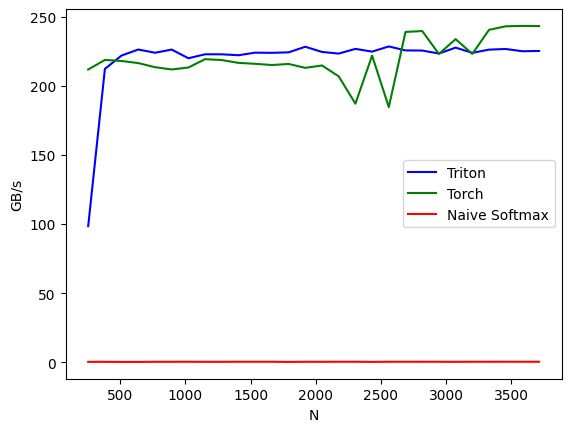

In [6]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 30)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch', 'naive_softmax'],  # possible values for `line_arg``
        line_names=["Triton", "Torch", "Naive Softmax"],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: softmax(x))
    if provider == 'naive_softmax':
        ms = triton.testing.do_bench(lambda: streaming_pytorch_softmax(x))
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)


benchmark.run(show_plots=True, print_data=False)